In [121]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from numpy.fft import fftn, ifftn, fftshift, ifftshift

np.random.seed(30)

In [122]:
image = Image.open('input.jpg')

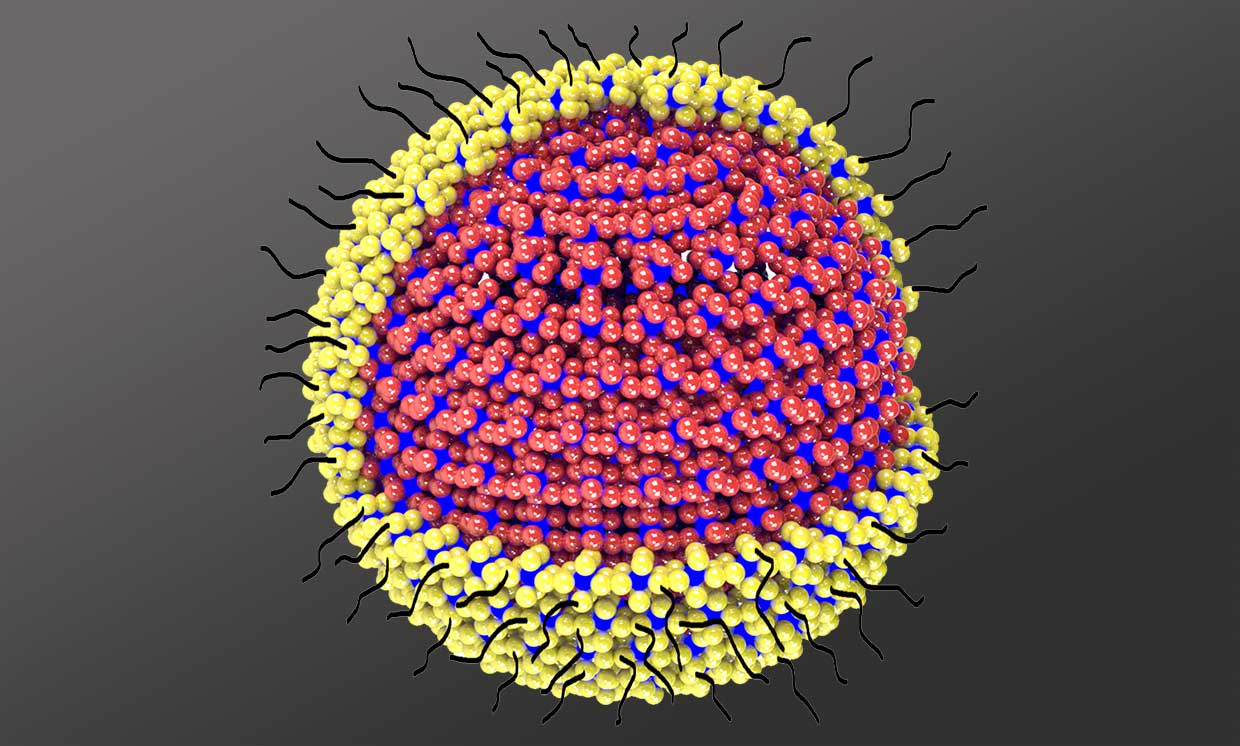

In [4]:
image

In [123]:
image.size

(1240, 746)

In [124]:
#crop image
# Setting the points for cropped image
left = 247
top = 0
right = 1240-247
bottom = 746
 
# Cropped image of above dimension
# (It will not change original image)
im_crop = image.crop((left, top, right, bottom)) #top should be smaller than bottom
print("size after crop: ", im_crop.size)

newsize = (128, 128)

im_crop_resize = im_crop.resize(newsize)

#padding
pad_width = int(128 / 2)
pad_height = int(128 / 2)
padding = (pad_width, pad_height, pad_width, pad_height)

im_crop_resize_padd = ImageOps.expand(im_crop_resize, padding, fill = (68,68,68))


# applying grayscale method
image_gray = ImageOps.grayscale(im_crop_resize_padd)
print("size after resize, padding, and gray: ", image_gray.size)




size after crop:  (746, 746)
size after resize, padding, and gray:  (256, 256)


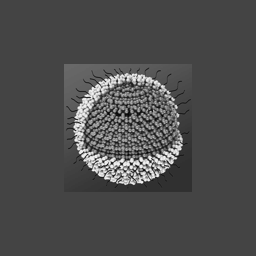

In [125]:
image_gray

In [126]:
#rescale, it will auto convert to numpy array
image_gray /= np.max(image_gray)
x_true = image_gray

In [127]:
x_true

array([[0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102],
       [0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102],
       [0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102],
       ...,
       [0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102],
       [0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102],
       [0.27755102, 0.27755102, 0.27755102, ..., 0.27755102, 0.27755102,
        0.27755102]])

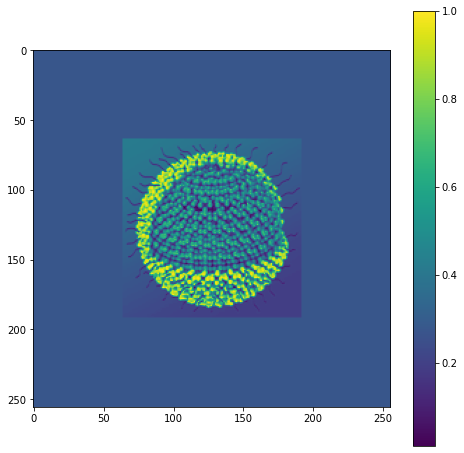

In [128]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(x_true)
plt.colorbar(im)
plt.show()

In [129]:
#fourier transform
X_true = fftn(x_true)
M_true = np.abs(X_true)

In [130]:
# support
supp = np.zeros([256,256])
supp[64:256-64, 64:256-64] = 1


Text(0.5, 1.0, 'Fourier transformed magnitude')

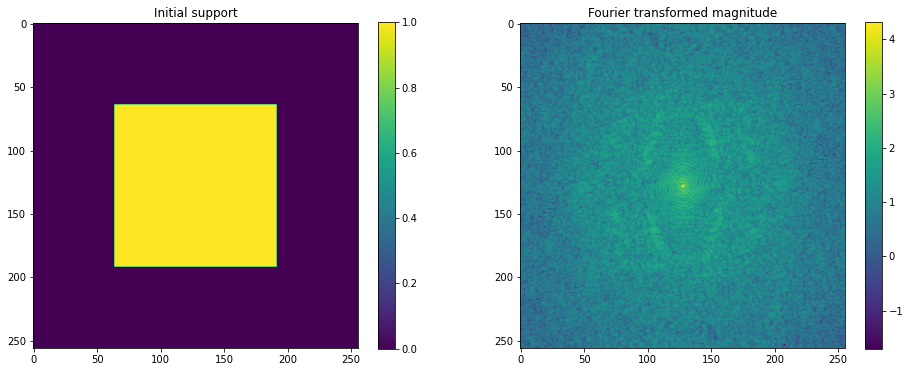

In [131]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(121)
im = ax.imshow(supp)
plt.colorbar(im)
ax.set_title('Initial support')

ax = fig.add_subplot(122)
# im = ax.imshow(np.log10(im_ft_abs)) # default using (0,0) which gives weird patterns at four corner 
im = ax.imshow(fftshift(np.log10(M_true))) #shift to the center
plt.colorbar(im)
ax.set_title('Fourier transformed magnitude')

# Projection operators

In [103]:
def P_S(x, S_in):
    #support constrain. zero if outside the support
    return x * S_in['supp']

In [105]:
def P_M(x, M_in):
    #magnitude constrain. all positive
    X  = fftn(x)
    
    X_new = X/np.abs(X) * M_in['M_data']
    # or
#     X_new = M_in['M_data'] * np.exp(1j * np.angle(X))
    
    x_new = ifftn(X_new)
    
    return x_new


# The difference map
$$ x_{n+1} = x_n + \beta (P_M R_S x_n - P_S R_M x_n)$$
where
$$R_M x = (1 + \gamma_M)P_M x - \gamma_M x$$
$$R_S x = (1 + \gamma_S)P_S x - \gamma_S x$$
and $\beta$ is a number btw 0 and 1.

https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-20-1-40

In [119]:
def R_M(x, gamma_M, M_in):
    #relaxed projection
    return (1+gamma_M)*P_M(x, M_in) - gamma_M * x

def R_S(x, gamma_S, S_in):
    return (1+gamma_S)*P_S(x, S_in) - gamma_S * x

def DM(x, beta, gamma_S, gamma_M, M_in, S_in):
    x_PMRS = P_M(R_S(x, gamma_S, S_in), M_in)
    x_PSRM = P_S(R_M(x, gamma_M, M_in), S_in)
    
    x_new = x + beta*(x_PMRS - x_PSRM)
    
    return x_new, x_PSRM
    

# shrinkwrap
# low-pass filtering

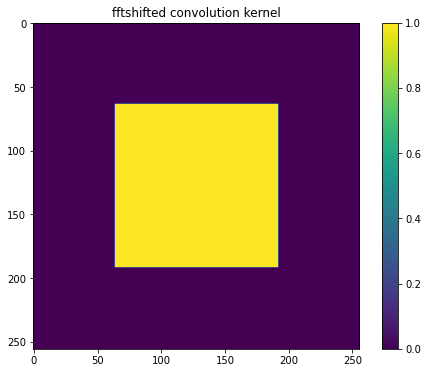

In [111]:
C_lp = np.zeros((256,256))
C_lp[64:256-64, 64:256-64] = 1
C_lp = ifftshift(C_lp)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
im = ax.imshow(fftshift(C_lp))
ax.set_title('fftshifted convolution kernel')
plt.colorbar(im)

plt.show()

In [112]:
def convolution_filter(x, kernel):
    return ifftn(fftn(x) * kernel)

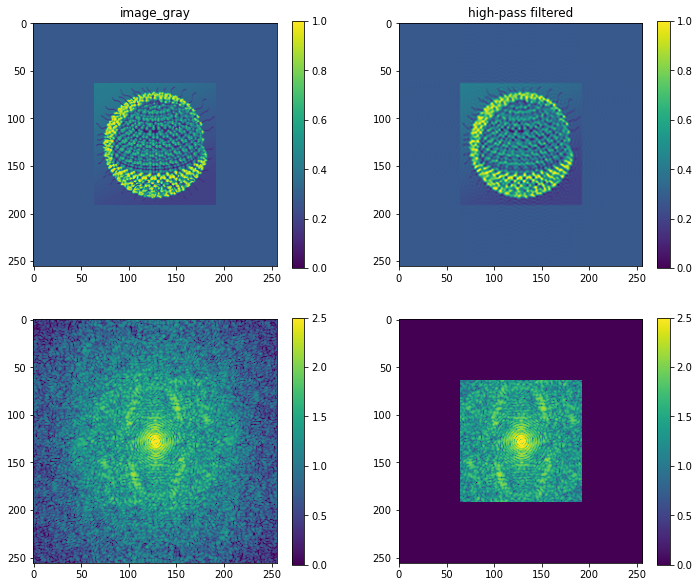

In [117]:
x_lp = convolution_filter(x_true, C_lp)

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(221)
im = ax.imshow(x_true, clim=[0,1])
plt.colorbar(im)
ax.set_title('image_gray')

ax = fig.add_subplot(222)
im = ax.imshow(np.abs(x_lp), clim=[0,1])
plt.colorbar(im)
ax.set_title('high-pass filtered')

ax = fig.add_subplot(223)
im = ax.imshow(np.log10(np.abs(fftshift(fftn(x_true)))), clim=[0,2.5])
plt.colorbar(im)

ax = fig.add_subplot(224)
im = ax.imshow(fftshift(np.log10(np.abs(fftn(x_true))) * C_lp), clim=[0,2.5])
plt.colorbar(im)

plt.show()

# high-pass filtering

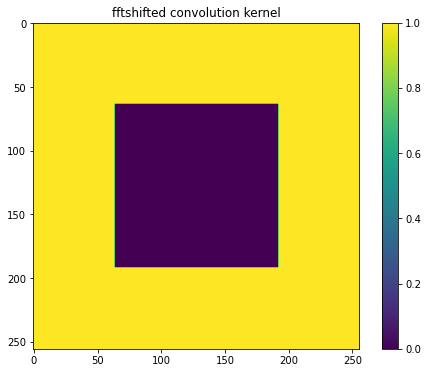

In [114]:
C_hp = 1 - C_lp

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
im = ax.imshow(fftshift(C_hp))
ax.set_title('fftshifted convolution kernel')
plt.colorbar(im)

plt.show()

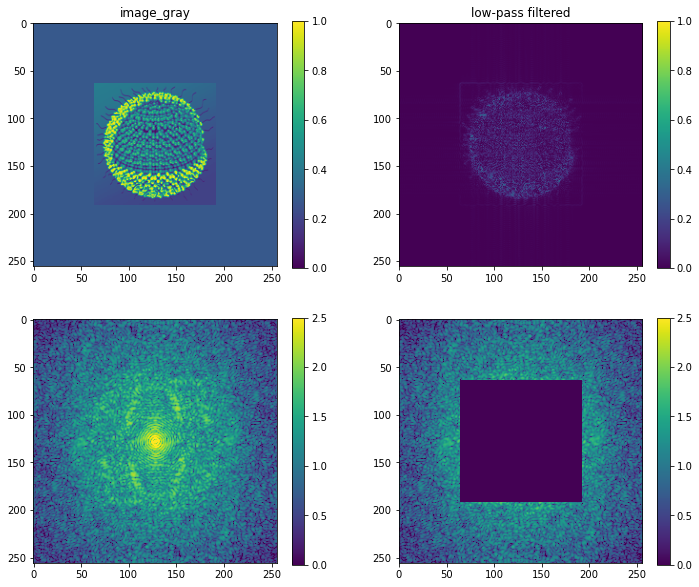

In [132]:
x_hp = convolution_filter(x_true, C_hp)

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(221)
im = ax.imshow(x_true, clim=[0,1])
plt.colorbar(im)
ax.set_title('image_gray')

ax = fig.add_subplot(222)
im = ax.imshow(np.abs(x_hp), clim=[0,1])
plt.colorbar(im)
ax.set_title('low-pass filtered')

ax = fig.add_subplot(223)
im = ax.imshow(np.log10(np.abs(fftshift(fftn(x_true)))), clim=[0,2.5])
plt.colorbar(im)

ax = fig.add_subplot(224)
im = ax.imshow(fftshift(np.log10(np.abs(fftn(x_true))) * C_hp), clim=[0,2.5])
plt.colorbar(im)

plt.show()

# phase retrieval

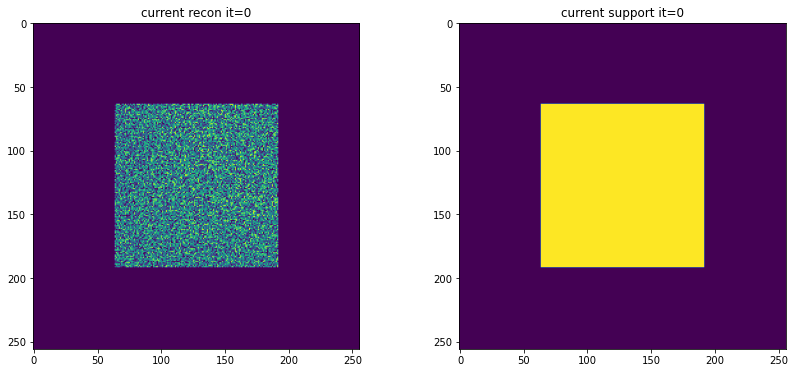

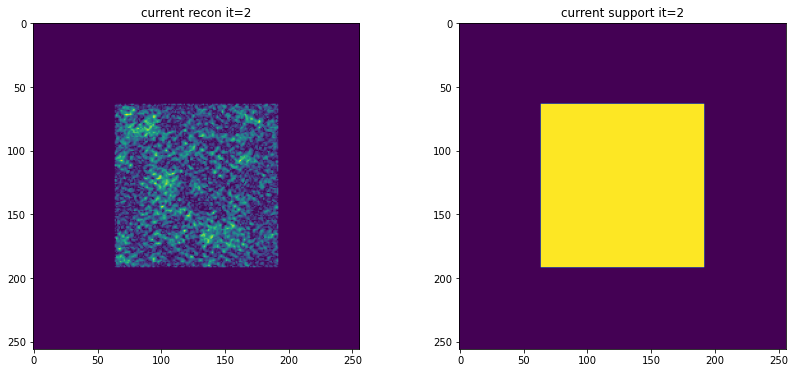

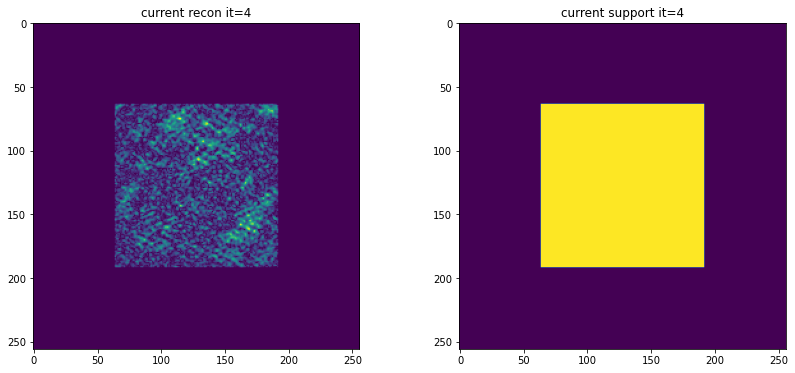

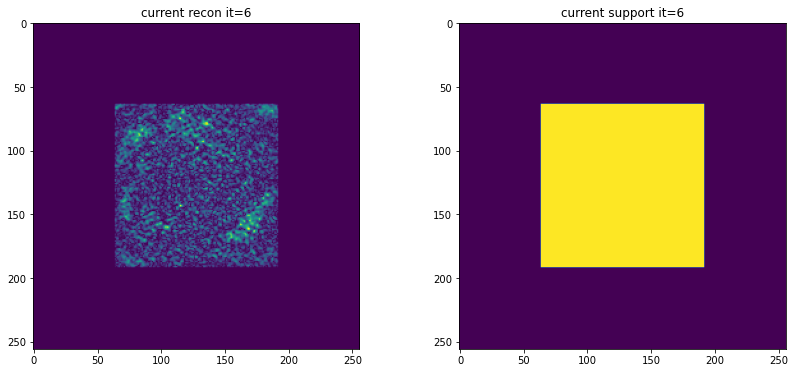

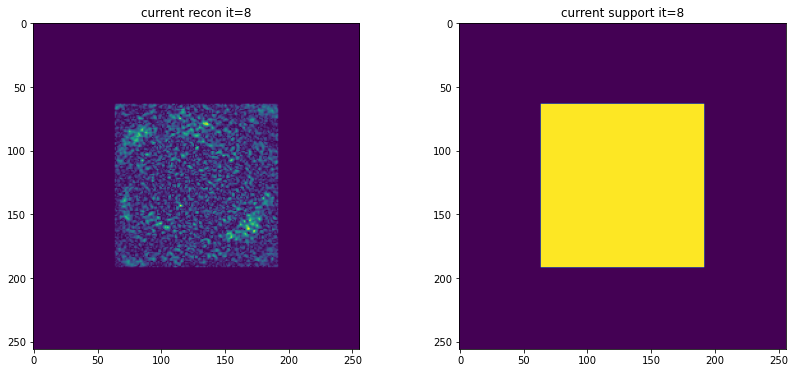

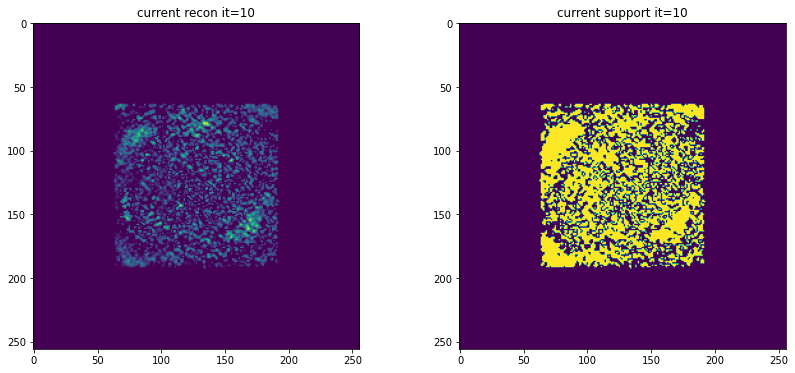

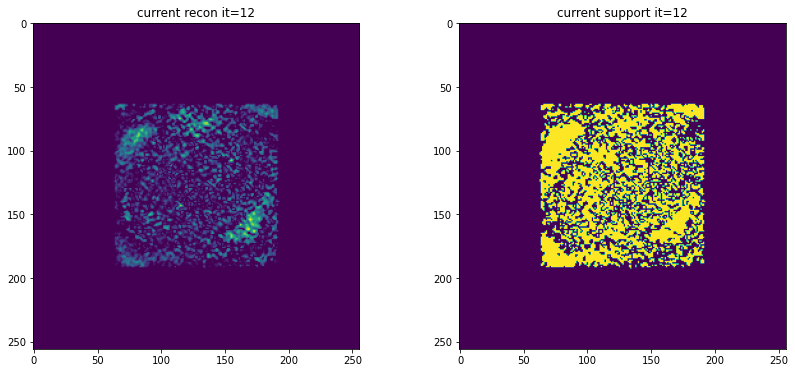

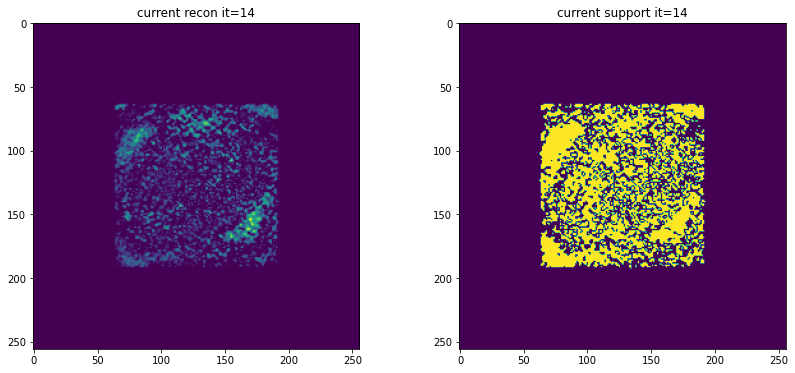

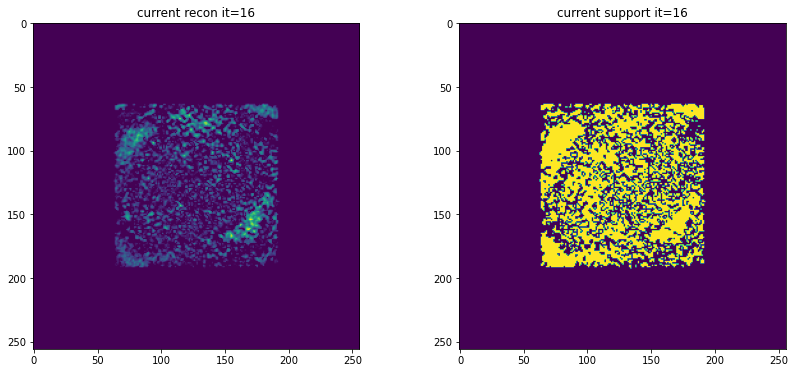

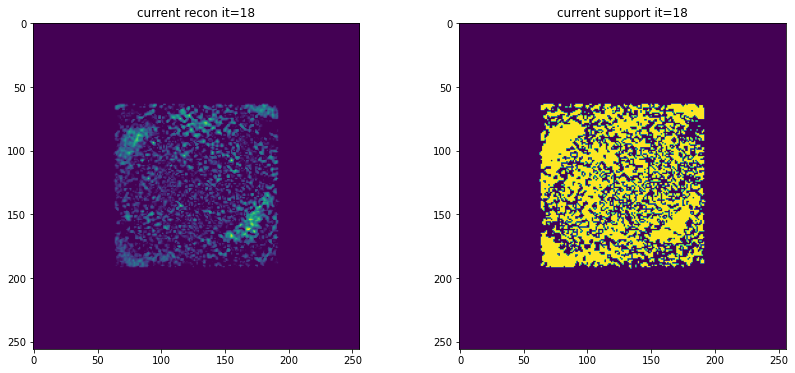

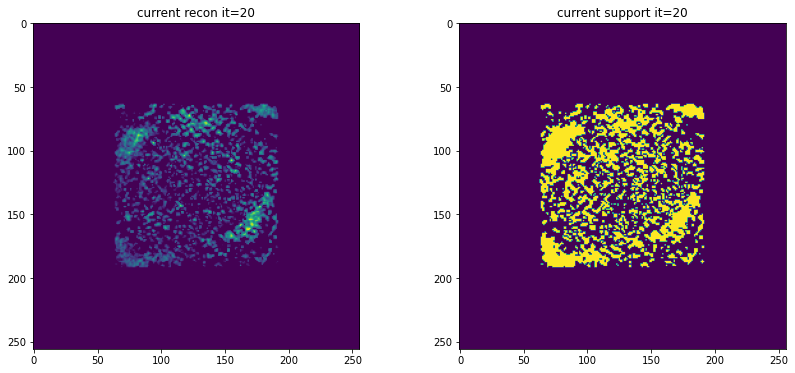

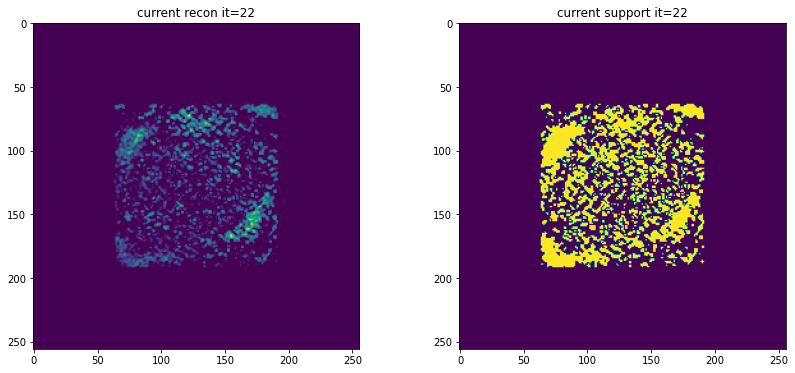

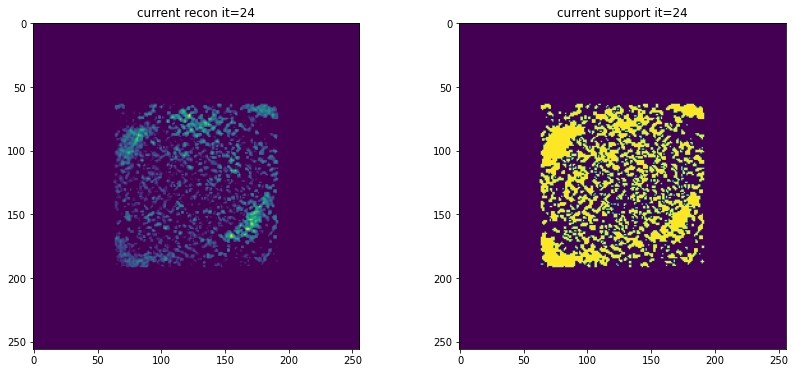

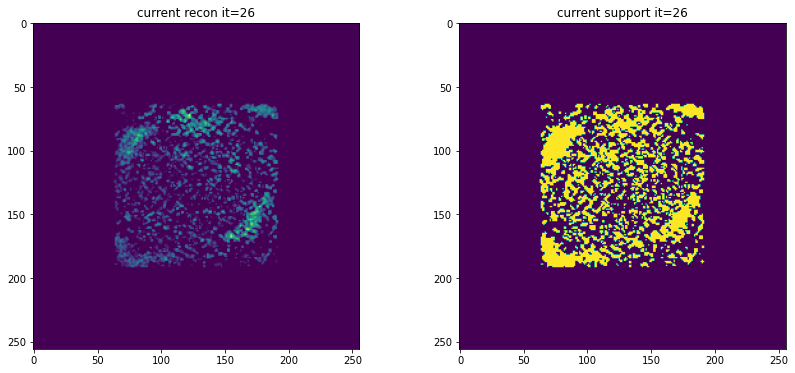

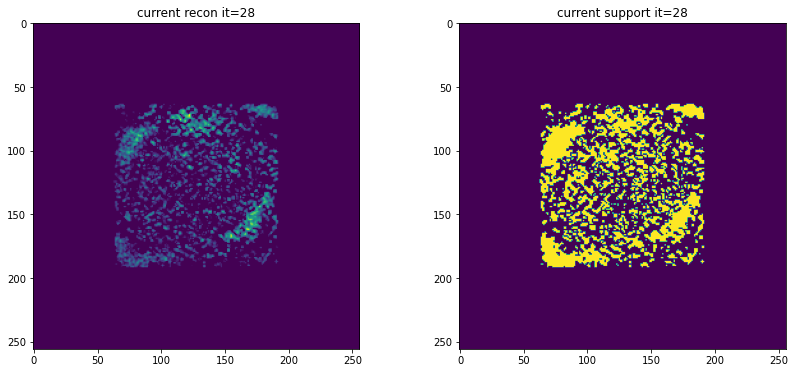

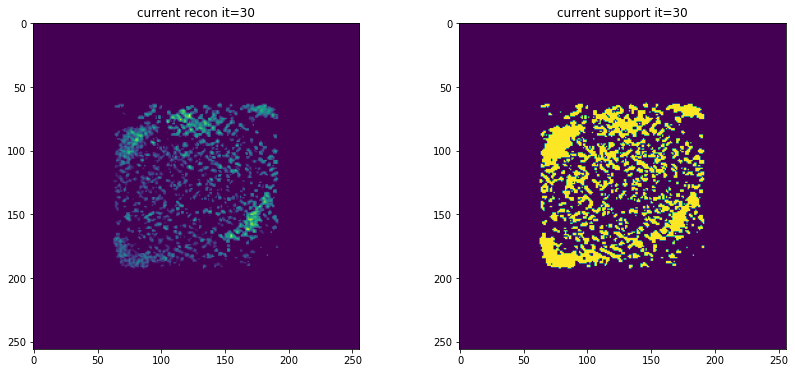

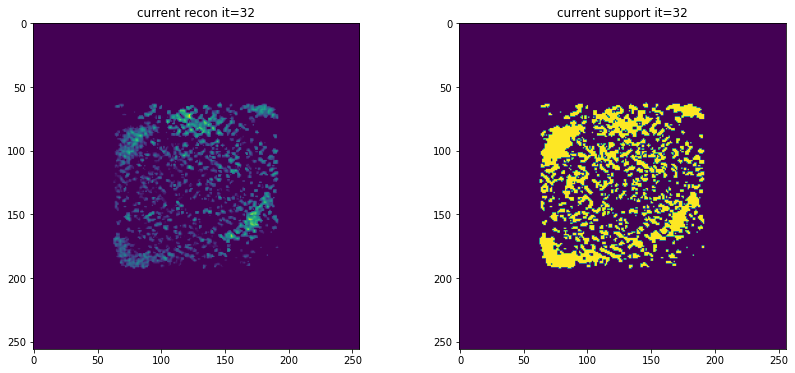

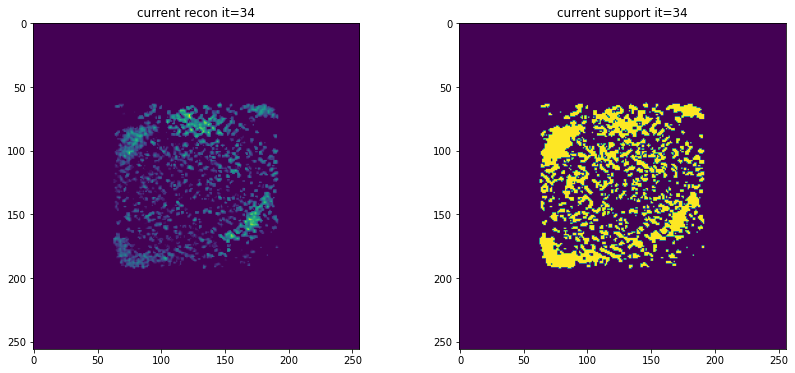

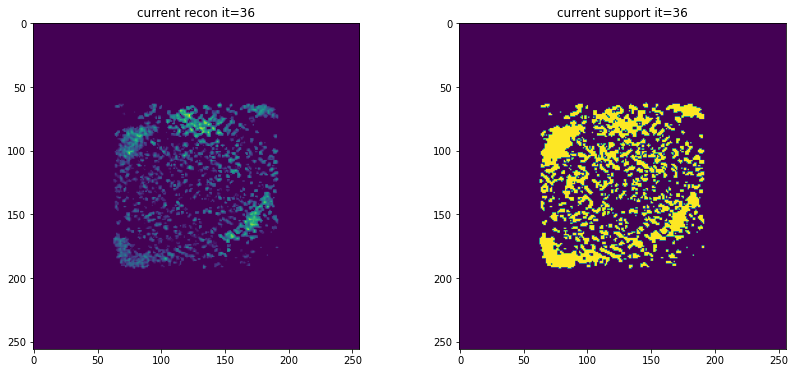

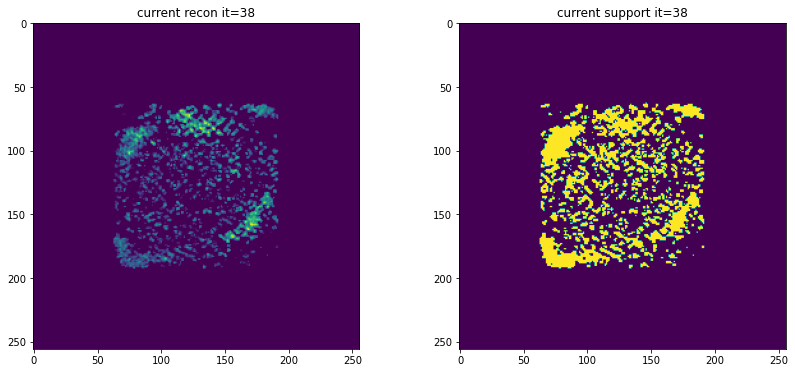

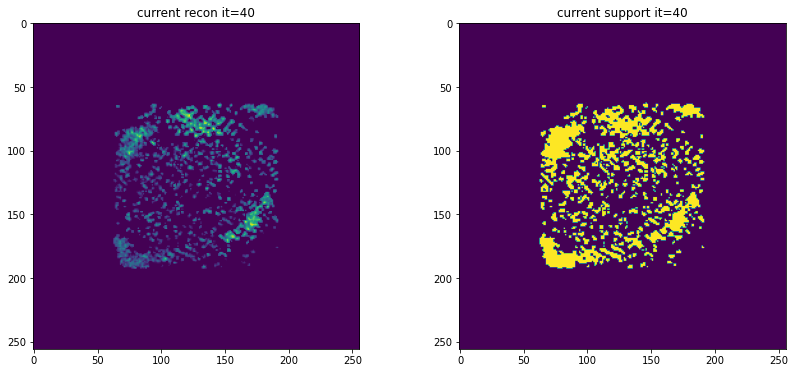

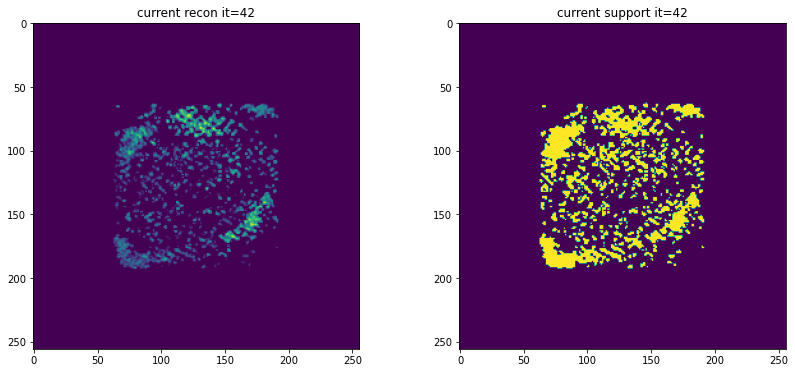

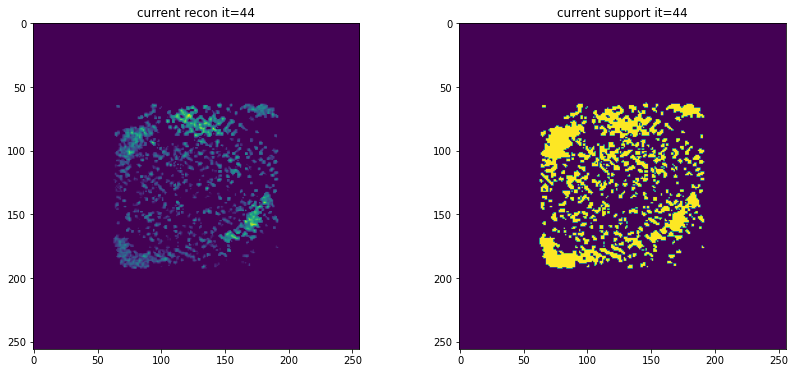

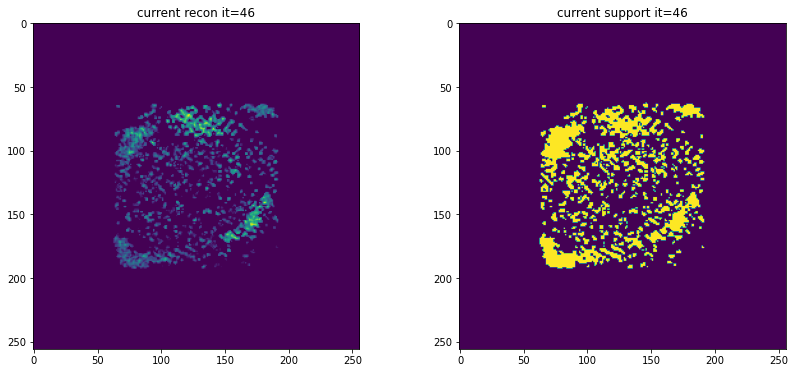

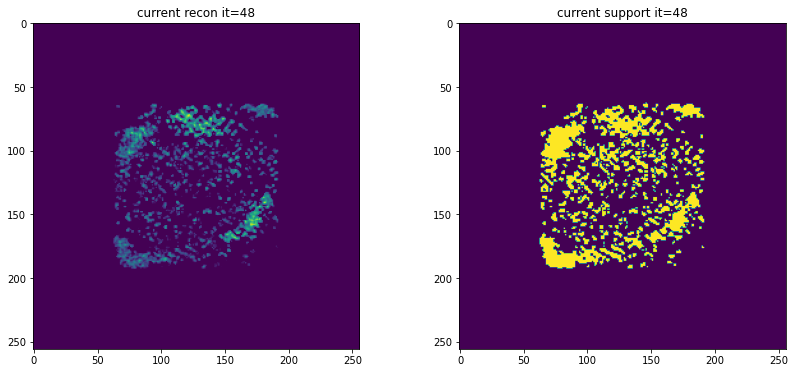

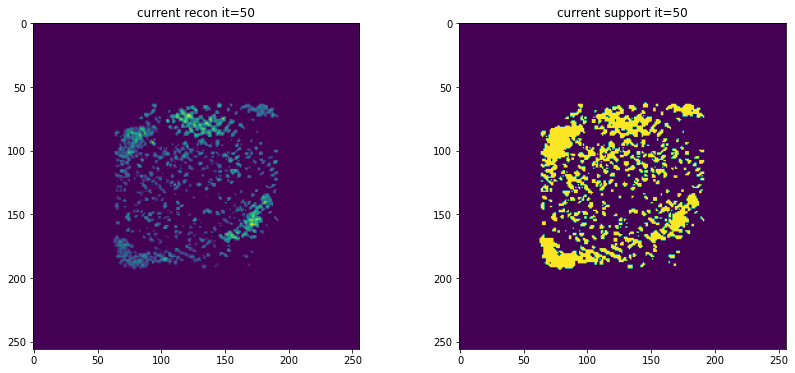

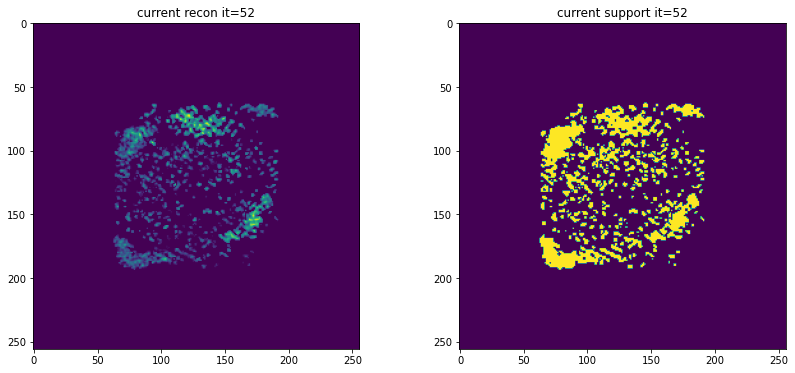

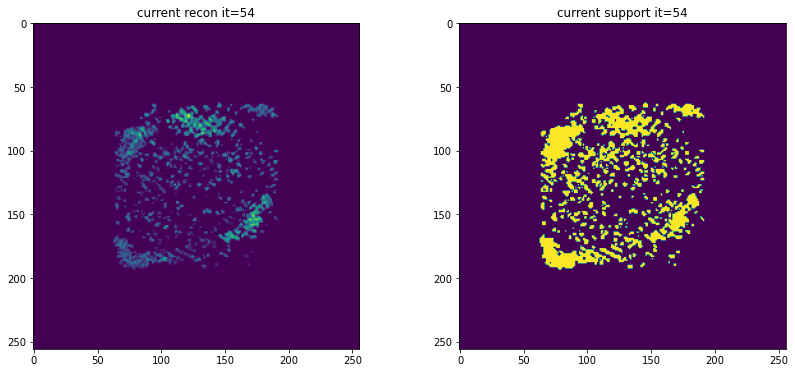

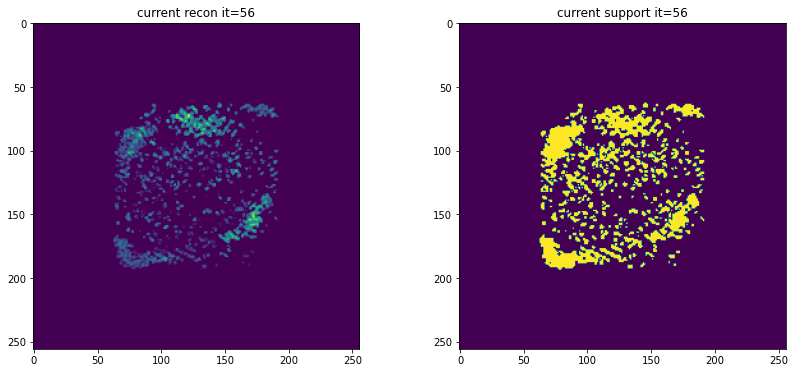

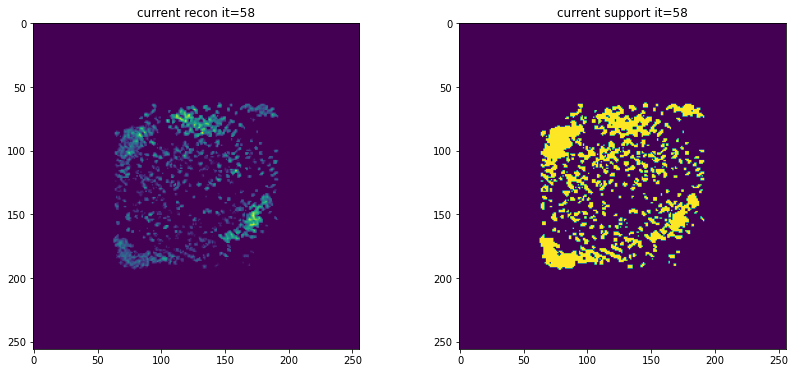

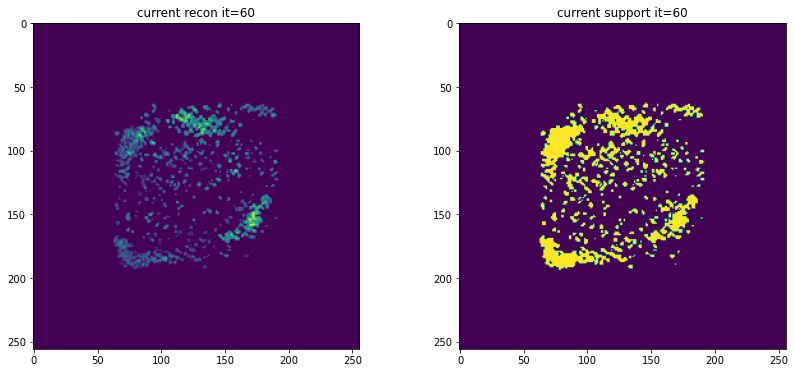

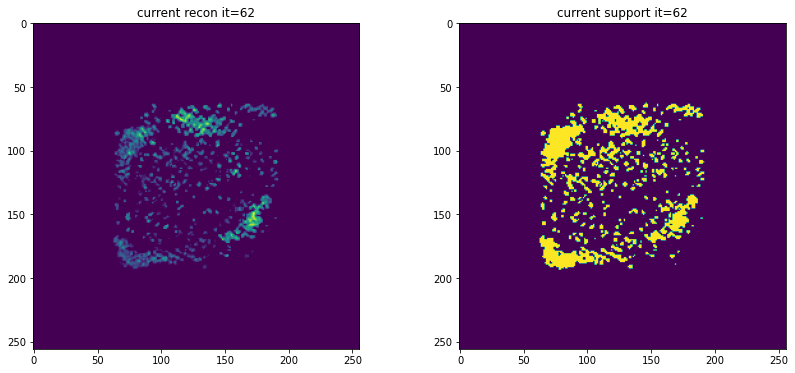

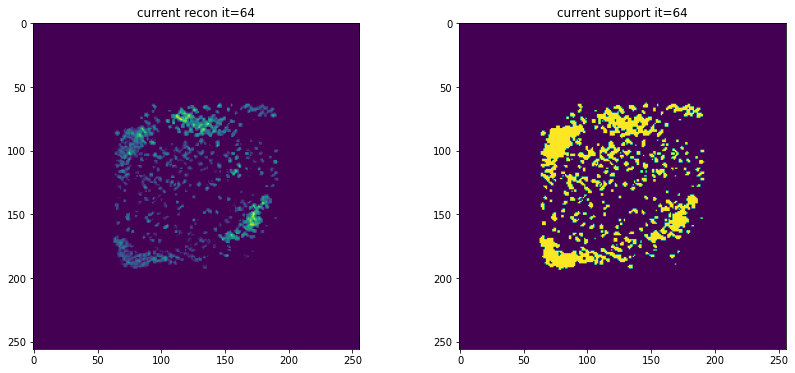

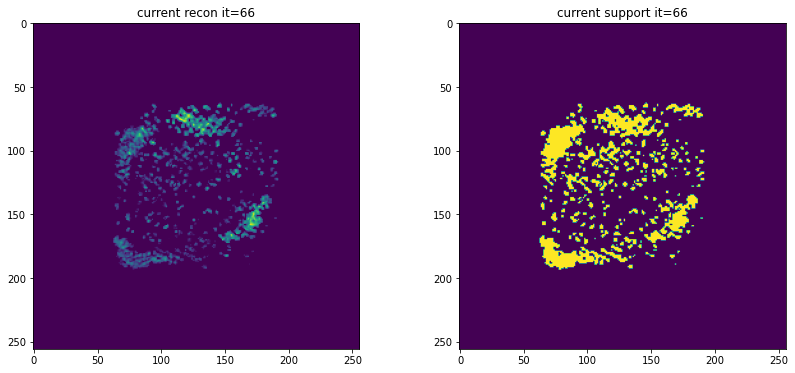

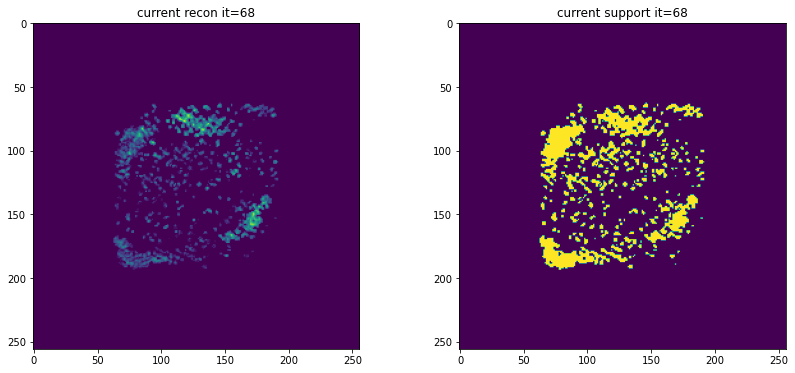

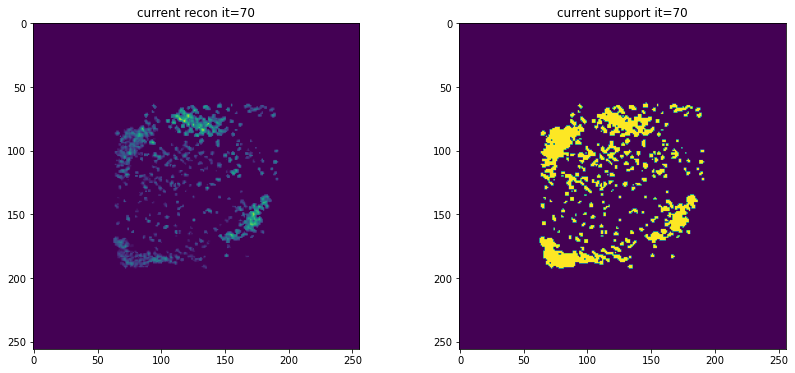

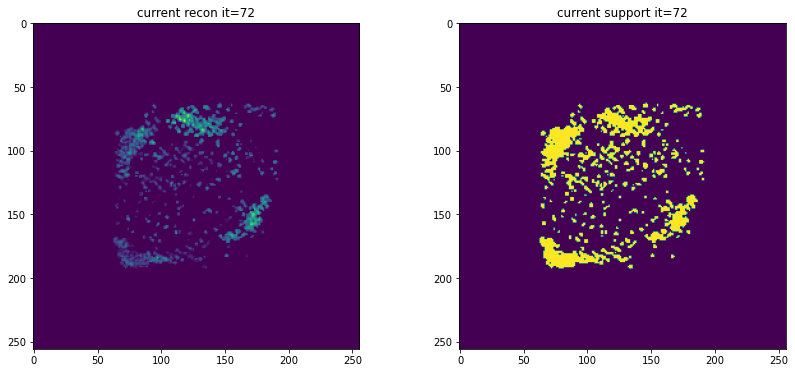

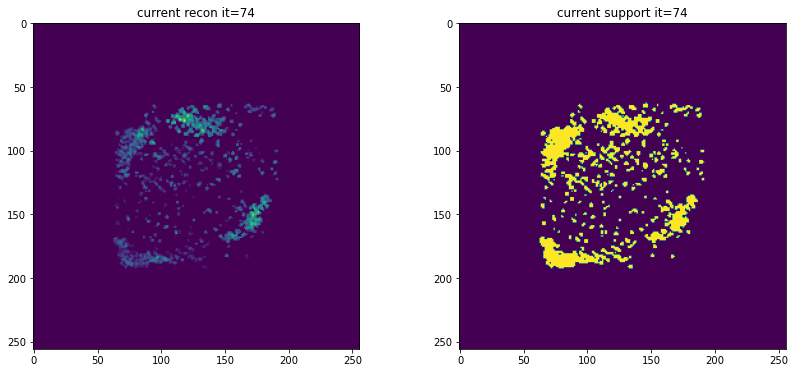

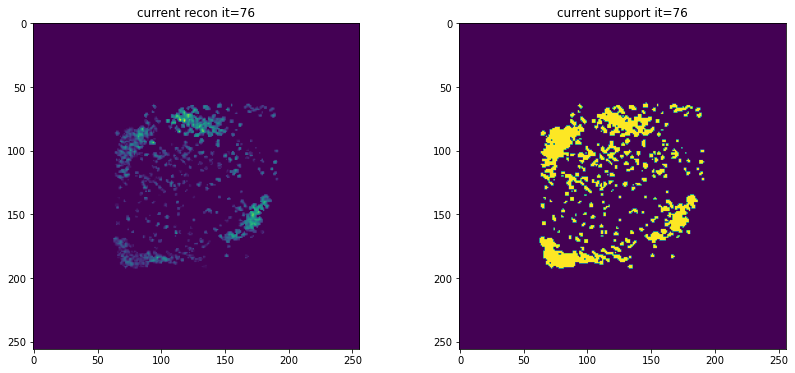

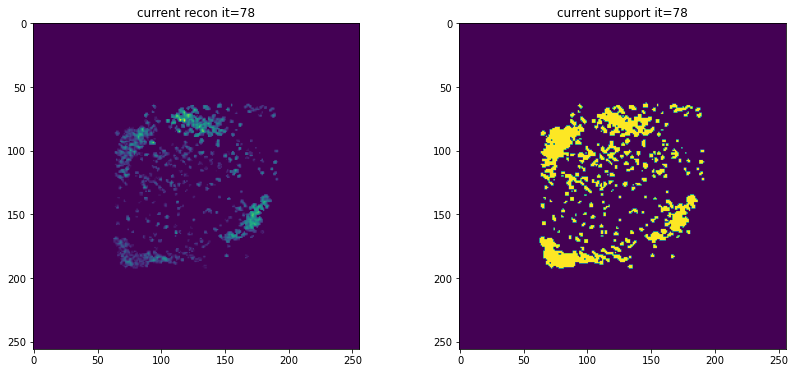

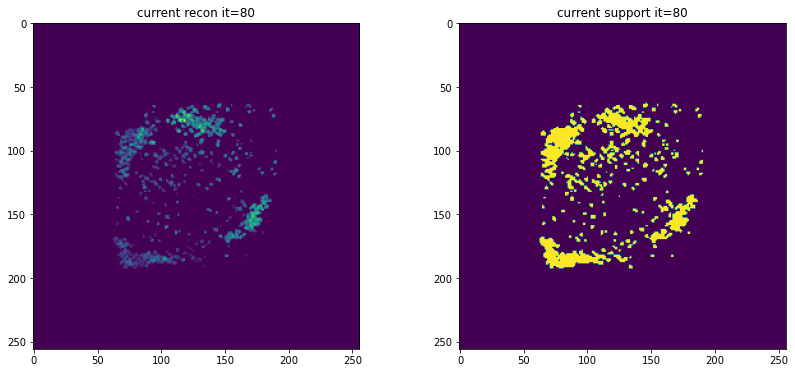

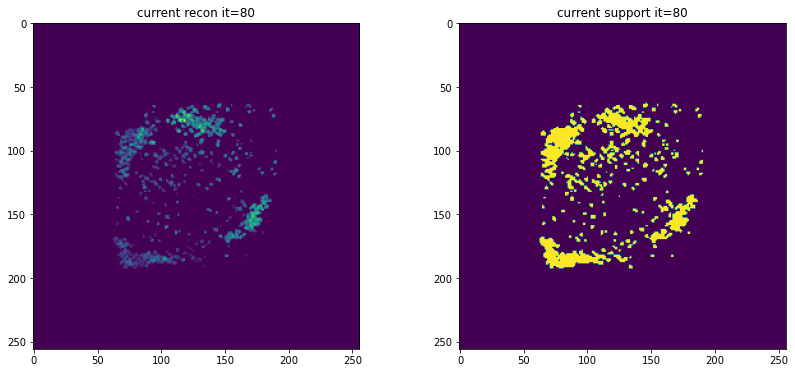

In [143]:
from IPython import display
import time

#initialize again
X_true = fftn(x_true)
M_true = np.abs(X_true)

supp = np.zeros([256,256])
supp[64:256-64, 64:256-64] = 1


#inputs
S_in = {'supp': supp}
M_in = {'M_data': M_true} #M_true = np.abs(X_true)

it_max = 81

#DM parameters
beta = 0.7 # small value means small change
gamma_M = -1/beta #random projections and the optimization of an algorithm for phase retrieval
gamma_S = 1/beta

#start iteration
x = np.random.rand(256,256)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for it in range(it_max):
    #update according to difference map
    x, x_PS = DM(x, beta, gamma_S, gamma_M, M_in, S_in)
    
    x_sol = x_PS
    
    #shrinkwrap every 10 iterations
    if it % 10 == 9:
        x_mod = convolution_filter(x_sol, kernel=C_lp)
        x_mod = np.abs(x_mod)
        x_mod /=np.max(x_mod)
        supp = x_mod > 0.12 # choose a threshold
        S_in = {'supp': supp}
        
    if it % 2 == 0:
        #plot
        im = ax1.imshow(np.abs(x_sol))
        ax1.set_title('current recon it=%d' % it)
        im = ax2.imshow(supp)
        ax2.set_title('current support it=%d' % it)
        
#         display.clear.output(wait=True)
        display.display(plt.gcf())
        
        time.sleep(0.2)